In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from time import time

from gprob import normal, stack

np.random.seed(0)

This notebook gives another illustration of maximum-likelihood fitting of a parametric model to observation data.

# Laser thansmission through a cavity with frequency noise

The model will be inspired by optical physics. A laser beam is coupled to an optical cavity whose frequency undergoes random motion, and the transmission through the cavity is recorded using a photodide, which adds its own noise. The signal on the photodiode is described by the equation
$$I(t) = \frac{a}{1+(\Delta(t)/\kappa)^2} + \xi(t),$$
where $a$ and $\kappa$ are the resonance amplitude and linewidth of the optical cavity, $\xi(t)$ is the detection noise, and $\Delta(t)=\omega_L(t)-\omega_c(t)$ is the fluctuating laser-cavity frequency detuning.

We assume that the detection noise is white, $\langle \xi(t)\xi(t+\tau)\rangle=\sigma_m^2 \delta(\tau)$, that the laser frequency is linearly scanned, $\omega_L\propto t$, and that the cavity frequency undergoes Brownian motion, $\langle \omega_c(t)\omega_c(t+\tau)\rangle = \sigma_f^2 |\tau|$. We also suppose that the data is centered with respect to the $x$ axis, i. e. in the middle of the scan the laser-cavity detuning is zero.

The unknown parameters to find from likelihood fitting will be $\kappa$, $a$, $\sigma_m$ and $\sigma_f$. If we decided to use least-squares fitting of $I(t)$ instead, we would only be able to estimate the parameters that affect the mean of the distribution, namely $\kappa$ and $a$, but not the parameters that only affect the covariance, namely $\sigma_m$ and $\sigma_f$. 


We start by constructing the frequency noise model,

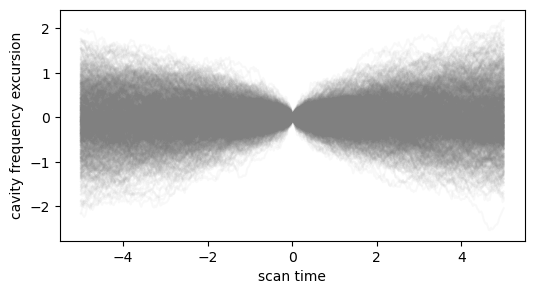

In [2]:
npts = 4 * 10**2
x = np.linspace(-5, 5, npts)

freq = [None] * npts
freq[0] = normal(0, 100)  # the unknown initial state
for i in range(npts-1):
    freq[i+1] = freq[i] + normal(0, 1/(npts-1))

freqs = stack(freq) | {freq[npts//2]: 0}

nsample = 10**3
samples = freqs.sample(nsample)

_ = plt.figure(figsize=(6, 3))
plt.plot(x, samples.T, alpha=0.05, color='gray')
plt.xlabel("scan time")
plt.ylabel("cavity frequency excursion");

Making a model for the cavity transmission and adding the detection noise,

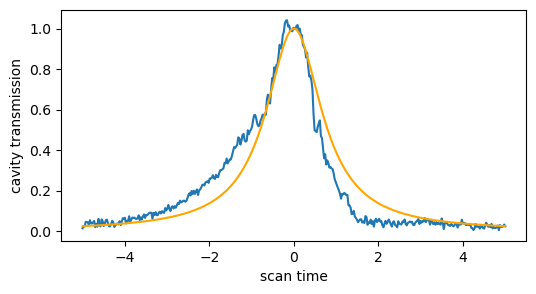

In [3]:
def lorentzian(x):
    return 1./(1. + x**2)


def lorentzian_model(a, lw, sigf, sigm):
    """Cavity transmission model.

    Args:
        a: amplitude
        lw: linewidth 
        sigf: magnitude of the frequency noise
        sigm: magnitude of the detection noise    
    """
    return a * lorentzian((sigf * freqs + x)/lw) + sigm * mn


mn = normal(0, 1, size=npts)  # detection noise

p_true = (1, 0.8, 0.9, 0.01)  # "true" parameters
tm = lorentzian_model(*p_true)

_ = plt.figure(figsize=(6, 3))
plt.plot(x, tm.sample().T);
plt.plot(x, lorentzian(x/0.8), color='orange')
plt.xlabel("scan time")
plt.ylabel("cavity transmission");

The model above is linearized with respect to all the random variables. It therefore has some linearization error, which we can see by comparing sampling from it with exact sampling. When the noises are small enough, this error is negligible.

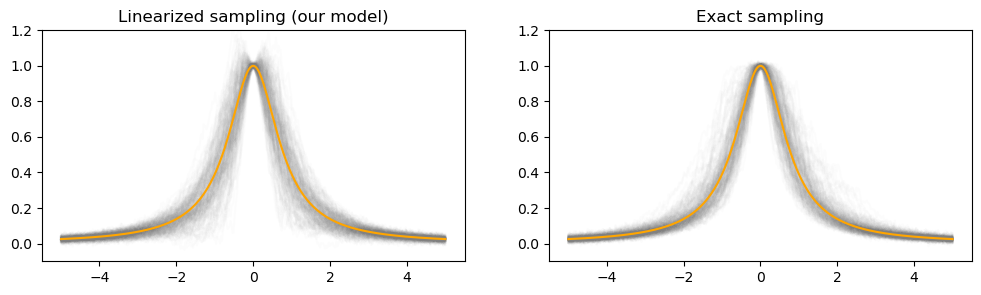

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(x, tm.sample(2 * 10**2).T, alpha=0.02, color='gray')
ax1.plot(x, lorentzian(x/0.8), color='orange')
ax1.set_ylim(-0.1, 1.2)
ax1.set_title("Linearized sampling (our model)")

ax2.plot(x, (lorentzian((0.7 * freqs + x).sample(2 * 10**2)/0.8) + 0.01 * mn.sample(2 * 10**2)).T, alpha=0.02, color='gray');
ax2.plot(x, lorentzian(x/0.8), color='orange')
ax2.set_ylim(-0.1, 1.2)
ax2.set_title("Exact sampling");

# Maximum likelihood fitting

First, we take one sample from the model itself to represent the "true" data to be fitted,

In [5]:
y = tm.sample()

The fitting can be implemented numerically using scipy `minimize`,

In [6]:
def cross_entropy(args):
    model = lorentzian_model(*args)
    return -model.logp(y)

p0 = np.array([0., 1.5, 1, 1])  # initial point

t0 = time()
min_sol1 = minimize(cross_entropy, p0)
print(f"Solution time: {time() - t0:.3g} s")
print(f"Optimum parameters: {min_sol1['x']}")
print(f"Relative errors: {(np.abs(min_sol1['x'])-p_true)/p_true}")

Solution time: 4.54 s
Optimum parameters: [ 0.99840706  0.74015844  0.95011984 -0.0102927 ]
Relative errors: [-0.00159294 -0.07480195  0.05568871  0.0292704 ]


The solution in this case is ok, as we can see from the errors. The optimizer, however, may complain about the precision loss due to numeric differentiation.

In [7]:
min_sol1['message']

'Desired error not necessarily achieved due to precision loss.'